In [1]:
import requests 
from dashboard_configs import league_id
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Step 1 get all the users in a given league
endpoint = f'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'
response = requests.get(endpoint).json()
standings = pd.DataFrame(response['standings']['results'])

In [3]:
standings.head()

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,10303098,78,Niklas Wietzorrek,1,3,1,146,1742534,CanceloCulture
1,11045904,70,Connor McDonald,2,6,2,133,534613,Darwin Award
2,62382206,78,Cam Jacobsz,2,0,3,133,2122857,BringBackDaMane
3,11191718,71,Liam Smorfitt,4,10,4,130,1930701,PK fc
4,44640726,64,Jason Perry,5,6,5,127,3648627,Change Name


In [4]:
#Step 2a get favourite club names and ID'sandbox.ipynb
endpoint = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(endpoint).json()
teams = pd.DataFrame(response['teams']).iloc[:, [3,5]]

In [5]:
teams.rename(columns = {'id':'club_id', 'name':'club'}, inplace = True)
teams.head()

,club_id,club
0,1,Arsenal
1,2,Aston Villa
2,3,Bournemouth
3,4,Brentford
4,5,Brighton


In [6]:
# Step 2b get each managers information 
# manager_id = 6896205
# endpoint = f' https://fantasy.premierleague.com/api/entry/{manager_id}/'
# response = requests.get(endpoint).json()
# favourite_team = response['favourite_team']
# manager_region = response["player_region_name"]

In [7]:
manager_ids = []
manager_clubs = []
manager_regions = []
for i in standings.entry:
    endpoint = f' https://fantasy.premierleague.com/api/entry/{i}/'
    response = requests.get(endpoint).json()
    favourite_club_id = response['favourite_team']
    region = response["player_region_name"]
    manager_ids.append(i)
    manager_clubs.append(favourite_club_id)
    manager_regions.append(region)

favourite_clubs_df = pd.DataFrame({'entry_id': manager_ids, 'club_id':manager_clubs, 'region': manager_regions})

In [8]:
standings = pd.merge(standings, favourite_clubs_df, left_on='entry', right_on='entry_id', how='left').drop('entry_id', axis=1)
standings = pd.merge(standings, teams, on="club_id", how="left")

In [9]:
standings.head()

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name,club_id,region,club
0,10303098,78,Niklas Wietzorrek,1,3,1,146,1742534,CanceloCulture,12.0,South Africa,Liverpool
1,11045904,70,Connor McDonald,2,6,2,133,534613,Darwin Award,12.0,South Africa,Liverpool
2,62382206,78,Cam Jacobsz,2,0,3,133,2122857,BringBackDaMane,12.0,South Africa,Liverpool
3,11191718,71,Liam Smorfitt,4,10,4,130,1930701,PK fc,14.0,South Africa,Man Utd
4,44640726,64,Jason Perry,5,6,5,127,3648627,Change Name,14.0,South Africa,Man Utd


In [10]:
favourite_clubs = standings.club.value_counts()
regions = standings.region.value_counts()

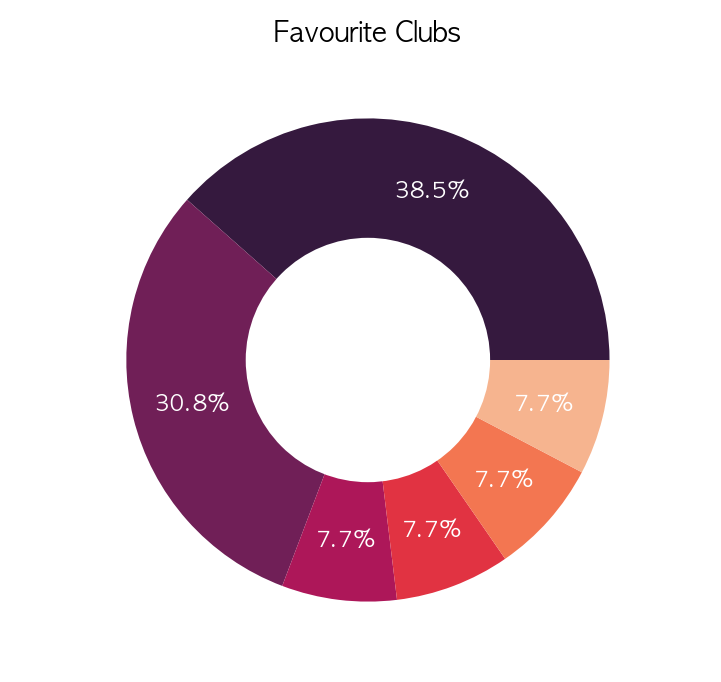

In [11]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams.update({'font.size': 8})

vals = favourite_clubs.values

clubs = favourite_clubs.index

num = len(favourite_clubs.index)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('rocket',num)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.5, color='white')

# create pie chart using matplotlib
plt.title('Favourite Clubs')
plt.pie(vals, labels=clubs, colors=colors, autopct='%1.1f%%', pctdistance=0.75, textprops={'color':"w"})
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

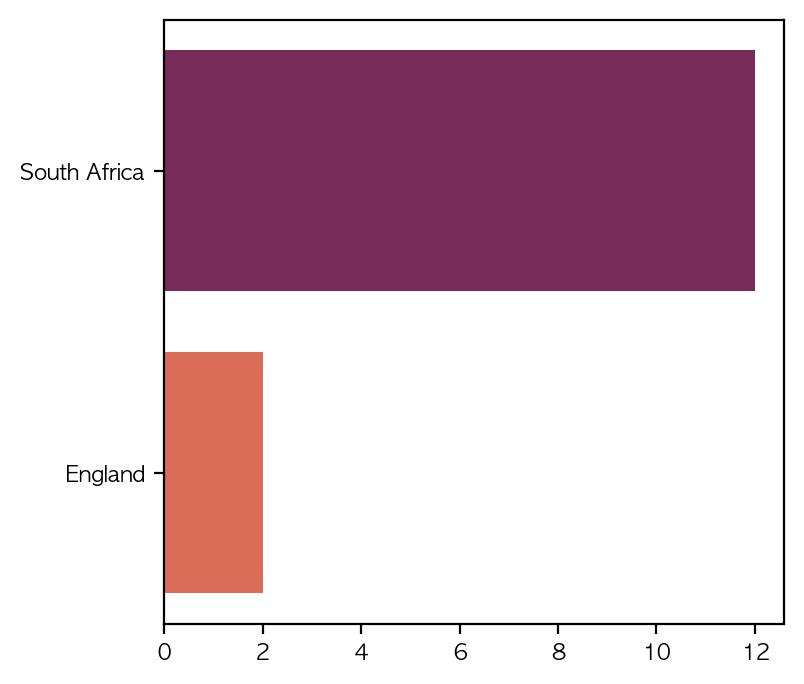

In [12]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams.update({'font.size': 8})

vals = regions.values

countries = regions.index

num = len(vals)

# Seaborn color palette to plot pie chart
colors = sns.color_palette('rocket',num)

sns.barplot(x=vals,y=countries, palette=colors)
plt.show()

In [13]:
# #TC 
# # 721791
# # manager_id = 3633274


# #BB AND TC
# manager_id = 6209589

# # free hit

# # manager_id = 6518355

# endpoint = f'https://fantasy.premierleague.com/api/entry/{manager_id}/history/'
# response = requests.get(endpoint).json()
# chips = response['chips']
# season = response['current']


In [14]:
season_df = pd.DataFrame()

for i in standings.entry:

    endpoint = f'https://fantasy.premierleague.com/api/entry/{i}/history/'
    response = requests.get(endpoint).json()
    season = response['current']
    temp_season_df = pd.DataFrame(season)

    m_id = []
    for j in range(len(season)):
        m_id.append(i)

    temp_season_df['entry'] = m_id

    season_df = season_df.append(temp_season_df, ignore_index=True)

    
season_df = pd.merge(season_df, standings[['entry','player_name']], on="entry", how="left")




In [15]:
max_pts = season_df.points.max()
max_pts_manager = season_df.loc[season_df['points'] == max_pts, 'player_name'].values
max_pts_manager = max_pts_manager[0]

In [16]:
sum_df = season_df.groupby('player_name').sum()
sum_df['points_bench_incl'] = sum_df.points + sum_df.points_on_bench
max_bench_pts = sum_df.points_on_bench.max()
max_bench_pts_manager = sum_df.loc[sum_df['points_on_bench'] == max_bench_pts].index


most_hits = sum_df.event_transfers_cost.max()
most_hits_manager = sum_df.loc[sum_df['event_transfers_cost'] == most_hits].index
most_hits_num = most_hits/4
most_hits_manager[0]
most_hits_num

sorted_by_bench = sum_df.sort_values(by='points_bench_incl', ascending=False).iloc[:, -1]

In [17]:
season_df.head()

,event,points,total_points,rank,rank_sort,overall_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry,player_name
0,1,68,68,1725839,1784744,1725838,0,1000,0,0,4,1742534,Niklas Wietzorrek
1,2,78,146,624576,634628,390415,0,1002,0,0,11,1742534,Niklas Wietzorrek
2,1,63,63,2753183,2775073,2753181,5,1000,0,0,4,534613,Connor McDonald
3,2,70,133,1773481,1780209,1526573,3,1000,1,0,11,534613,Connor McDonald
4,1,55,55,4586314,4643450,4586309,0,1000,0,0,5,2122857,Cam Jacobsz


In [18]:
best_rank = season_df.overall_rank.min()
best_rank_manager = season_df.loc[season_df['overall_rank'] == best_rank, 'player_name'].values
best_rank_gw = season_df.loc[season_df['overall_rank'] == best_rank, 'event'].values
best_rank_manager[0]
best_rank_gw[0]

2

In [19]:
std_df = season_df.iloc[:, [1,5,-1]].groupby('player_name').std()
min_std = std_df.points.min()
min_std_manager = std_df.loc[std_df['points'] == min_std].index.values
min_std_manager[0]

'Alex Wietzorrek'

In [20]:
#single GW
most_b_points = season_df.points_on_bench.max()
most_b_points_manager = season_df.loc[season_df['points_on_bench'] == most_b_points, 'player_name'].values
most_b_points_gw = season_df.loc[season_df['points_on_bench'] == most_b_points, 'event'].values
most_b_points_gw[0]
most_b_points_manager[0]

'Devon Hodgson'

In [21]:
TC = []
BB = []
FH = []
ids = []
for i in standings.entry:
    endpoint = f'https://fantasy.premierleague.com/api/entry/{i}/history/'
    response = requests.get(endpoint).json()
    chips = response['chips']
    season = response['current']

    if len(chips) == 0:
        TC.append(0)
        BB.append(0)
        FH.append(0)
        ids.append(i)

    else:
        for j in chips:
            if j['name'] == '3xc':
                TC.append(1)
            else:
                TC.append(0)

            if j['name'] == 'bboost':
                BB.append(1)
            else:
                BB.append(0)

            if j['name'] == 'freehit':
                FH.append(1)
            else:
                FH.append(0)

            ids.append(i)

chip_df =pd.DataFrame({'m_id': ids, 'used_tc': TC, 'used_bb': BB, 'used_fh': FH})



In [22]:
standings = pd.merge(standings, chip_df, left_on='entry', right_on='m_id', how='left').drop('m_id', axis=1)

In [23]:
standings

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name,club_id,region,club,used_tc,used_bb,used_fh
0,10303098,78,Niklas Wietzorrek,1,3,1,146,1742534,CanceloCulture,12.0,South Africa,Liverpool,1,0,0
1,11045904,70,Connor McDonald,2,6,2,133,534613,Darwin Award,12.0,South Africa,Liverpool,0,0,0
2,62382206,78,Cam Jacobsz,2,0,3,133,2122857,BringBackDaMane,12.0,South Africa,Liverpool,0,0,0
3,11191718,71,Liam Smorfitt,4,10,4,130,1930701,PK fc,14.0,South Africa,Man Utd,0,0,0
4,44640726,64,Jason Perry,5,6,5,127,3648627,Change Name,14.0,South Africa,Man Utd,0,0,0
5,11604984,57,Marco Gouveia,6,5,6,122,552345,Neves Say Never,1.0,South Africa,Arsenal,0,0,0
6,11600435,66,Cole Floyd,6,13,7,122,1947717,FatFloyd,10.0,South Africa,Leicester,0,0,0
7,42389877,62,Ryan Shacks,8,12,8,120,578302,Dier Straits,18.0,South Africa,Spurs,0,0,0
8,11044918,61,Alex Wietzorrek,9,8,9,119,560769,Shake ‘n Bake,NaN,South Africa,NaN,0,0,0
9,11163290,53,Devon Hodgson,10,8,10,115,1002132,Banterlona,14.0,England,Man Utd,0,0,0
